<a href="https://colab.research.google.com/github/azrielrisywan/team-assignment-2-ai-binus/blob/master/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Table of Contents**

1. Introduction
1. Import library
1. Fetch datasets from kaggle
1. Prepare training data
1. Data pre-processing
1. Model building
1. Prepare testing data
1. Find prediction



# **Introduction**

In this project, we'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats but our computer will find it a bit more difficult.
### Data Description
The folder "train" contains two sub-folders "cats" & "dogs" which contain images of cats and dogs respectively.The folder "test1" contain unknown images which we have to classify.
### Data
To download the Dataset click [here](https://www.kaggle.com/c/dogs-vs-cats/data)
### Objective
To build a deep learning classification model which classify whether images contain either a dog or a cat.



# Tambah dependency untuk hyperparameter tuning

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [2]:
!pip install kaggle

# **1. Import Library**

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img  # Perbarui impor
from tensorflow.keras.utils import to_categorical  # Perbarui impor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt  # Untuk hyperparameter tuning

# **2. Fetch datasets from kaggle**

In [4]:
# Step-1: create .kaggle directory
!mkdir ~/.kaggle

In [5]:
# Step-2: create a API token in your kaggle account.Upload this token("kaggle.json") on any folder here.move this file into ~/.kaggle.
# Below code is for moving ".json" file
!mv /content/sample_data/kaggle.json ~/.kaggle/kaggle.json

In [6]:
# Step-3: give authorization to KaggleApi
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Step-4: Download datasets from kaggle using API
!kaggle competitions download -c dogs-vs-cats

In [12]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/sample_data/train/train.zip')
zf.extractall('/content/sample_data/train') #save files in selected folder
zf.close()

# **3. Prepare Training Data**
Here we will create dataframe which will store all file names in "filenames" column and value "1" for "dog" and "0" for "cat".

In [13]:
filenames = os.listdir("/content/sample_data/train/train")
categories = []
for name in filenames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

image_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [14]:
# See top 5 rows of the dataset
image_df.head()

filename  category
0   cat.1556.jpg         0
1   cat.6536.jpg         0
2   cat.5894.jpg         0
3  dog.10399.jpg         1
4   cat.1755.jpg         0

In [15]:
# See buttom 5 cell of the dataset
image_df.tail()

filename  category
24995      dog.5.jpg         1
24996   cat.1451.jpg         0
24997  cat.12038.jpg         0
24998   dog.7546.jpg         1
24999   cat.1307.jpg         0

In [16]:
image_df.shape

(25000, 2)

<Axes: xlabel='category'>

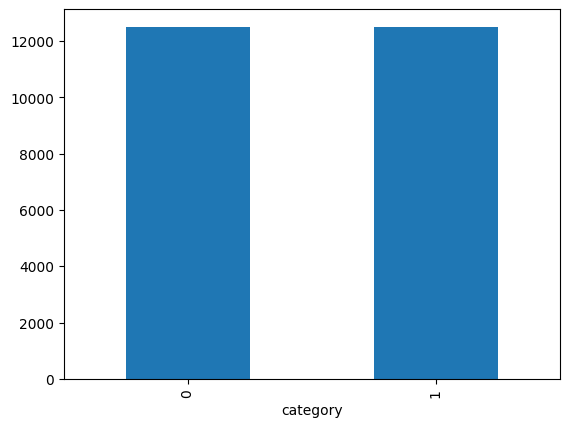

In [17]:
# visualize number of cats and dogs present in the dataframe
image_df['category'].value_counts().plot.bar()

## **3.1. Sample Image**

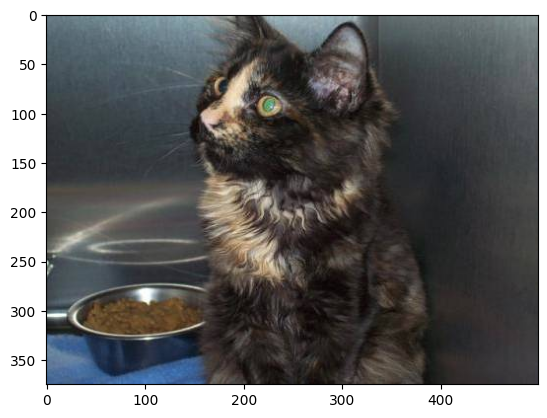

In [18]:
sample = random.choice(filenames)
image = load_img("/content/sample_data/train/train/"+sample)
plt.imshow(image)

# **4.Data Pre-processing**
As we use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding.

So we will convert 1 to "dog" and 0 to "cat"

In [19]:
# replace 0 as "cat" & 1 as "dog"
image_df["category"] = image_df["category"].replace({0: 'cat', 1: 'dog'})

In [20]:
# split the dataset for training & testing
train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=23)
# training dataset
train_df = train_df.reset_index(drop=True)
# testing dataset
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

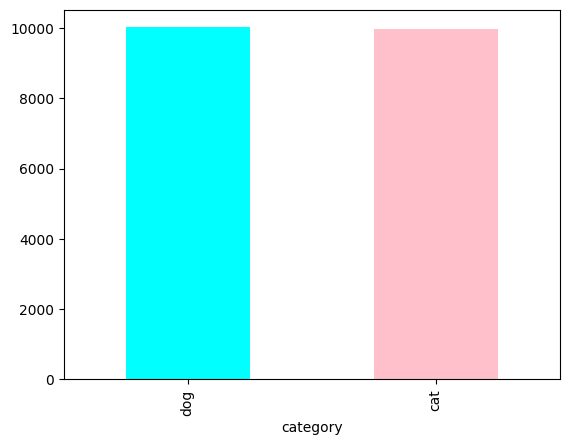

In [21]:
# see frequency of class variables in target column of training dataset
train_df['category'].value_counts().plot.bar(color=["cyan","pink"])

<Axes: xlabel='category'>

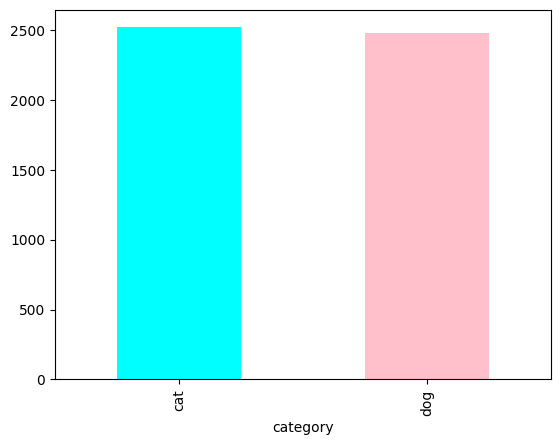

In [22]:
# see frequency of class variables in target column of testing dataset
validate_df['category'].value_counts().plot.bar(color=["cyan","pink"])

## **4.1. Define Constants**

In [23]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=4

In [24]:
train_df_size = train_df.shape[0]
validate_df_size = validate_df.shape[0]

## **4.2. Training Generator**

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/sample_data/train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## **4.3. Validation Generator**

In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/sample_data/train/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## **4.4. See how generator work**

In [27]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/sample_data/train/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


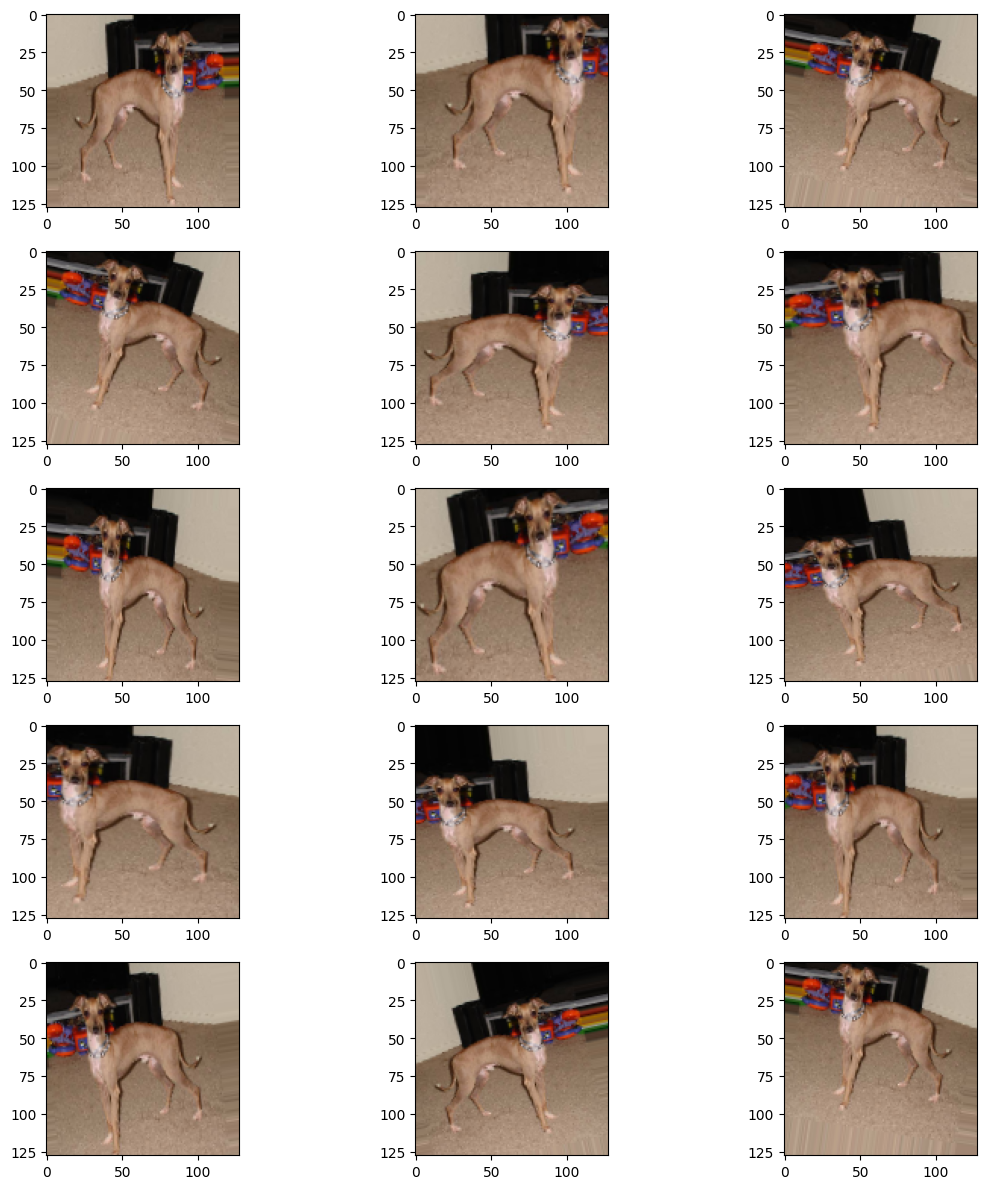

In [28]:
# visualize generated images from one image
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **5. Model Building**
<img src="https://media.geeksforgeeks.org/wp-content/uploads/cat-vs-dog.jpg" width="100%"/>

* **Conv Layer**: Convolutional layers are the layers where filters are applied to the original image, or to other feature maps in a deep CNN.
* **Conv2D Layer**: Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
* **Pooling Layer**: Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.
* **BatchNormalization**: Layer that normalizes its inputs.Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

* Pakai **Transfer Learning** untuk membuat training model lebih efektif dan menghasilkan model yang lebih baik

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_model(hp):
    base_model = MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                             include_top=False, weights='imagenet')
    base_model.trainable = False  # Bekukan bobot pre-trained

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(hp.Int('units', 128, 512, step=128), activation='relu'),
        Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Inisialisasi tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimalkan berdasarkan akurasi validasi
    max_trials=3,  # Coba 10 kombinasi hyperparameter
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cat_dog_tuning'
)

# Tampilkan ringkasan pencarian
tuner.search_space_summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


## **5.1. Callback Functions**
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.
- **EarlyStopping** : Used to avoid overfitting.Here we'll stop the training if there is no improvement in 3 conjecutive epochs.
- **ModelCheckpoint** : This callback saves the model after every epoch.The model'll save in a particular location with minimun 'val_loss'.
- **ReduceLROnPlateau** : It reduces learning rate when a metric has stopped improving.
For more about callback function click [here](https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html) [here](https://keras.io/api/callbacks/)

In [30]:
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/cd_model.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [31]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

In [32]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

## **5.2. Model Fitting**

In [33]:
start_time = timer(None)
tuner.search(
    train_generator,
    epochs=3 if FAST_RUN else 5,  # Kurangi epoch untuk testing cepat, idealnya 20-40
    validation_data=validation_generator,
    validation_steps=validate_df_size//batch_size,
    steps_per_epoch=train_df_size//batch_size,
    callbacks=callbacks
)
timer(start_time)

Trial 3 Complete [00h 11m 29s]
val_accuracy: 0.9649999737739563

Best val_accuracy So Far: 0.9661999940872192
Total elapsed time: 00h 35m 04s

 Time taken: 0 hours 35 minutes and 3.57 seconds. 


## **5.3. Save the Model**

In [34]:
# Ambil model terbaik
best_model = tuner.get_best_models(num_models=1)[0]

# Tampilkan ringkasan model terbaik
best_model.summary()

# Simpan model terbaik
best_model.save("cat_dog_classifier_tuned.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │       491,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,658 (10.49 MB)

 Trainable params: 492,674 (1.88 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **5.4. Load Model**

In [35]:
from keras.models import load_model
new_model = load_model('/content/cat_dog_classifier_tuned.h5')

## **5.5. Visualize training accuracy and loss**

Epoch 1/5
4999/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9549 - loss: 0.1239
Epoch 1: val_loss improved from inf to 0.10847, saving model to /content/sample_data/cd_model.h5


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 136s 26ms/step - accuracy: 0.9549 - loss: 0.1239 - val_accuracy: 0.9690 - val_loss: 0.1085 - learning_rate: 7.1548e-04
Epoch 2/5
4998/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9584 - loss: 0.1057
Epoch 2: val_loss improved from 0.10847 to 0.10284, saving model to /content/sample_data/cd_model.h5


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 127s 25ms/step - accuracy: 0.9584 - loss: 0.1057 - val_accuracy: 0.9644 - val_loss: 0.1028 - learning_rate: 7.1548e-04
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9606 - loss: 0.1030
Epoch 3: val_loss did not improve from 0.10284

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00035774221760220826.
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 25ms/step - accuracy: 0.9606 - loss: 0.1030 - val_accuracy: 0.9532 - val_loss: 0.1511 - learning_rate: 7.1548e-04
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9636 - loss: 0.0875
Epoch 4: val_loss did not improve from 0.10284
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 126s 25ms/step - accuracy: 0.9636 - loss: 0.0875 - val_accuracy: 0.9656 - val_loss: 0.1225 - learning_rate: 3.5774e-04
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9625 - loss: 0.0914
Epoch 5: val_loss did not improve from 0.10284

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00017887110

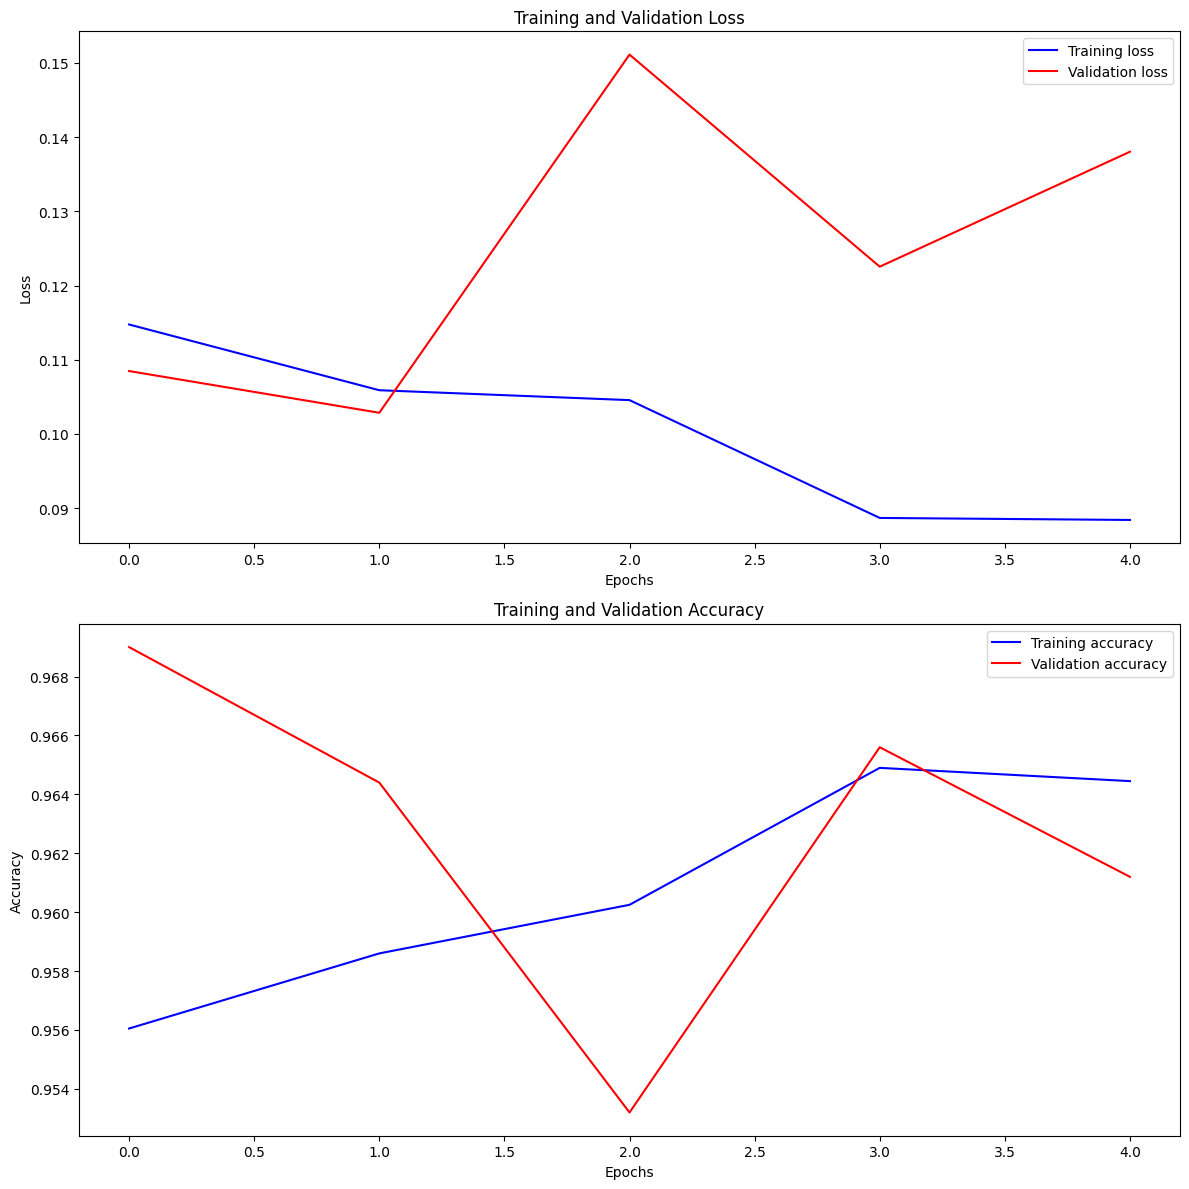

In [36]:
# Latih ulang model terbaik untuk mendapatkan history (opsional)
history = best_model.fit(
    train_generator,
    epochs=3 if FAST_RUN else 5,
    validation_data=validation_generator,
    validation_steps=validate_df_size//batch_size,
    steps_per_epoch=train_df_size//batch_size,
    callbacks=callbacks
)

# Visualisasi
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot training & validation loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# Plot training & validation accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_loss_tuned.png')
plt.show()

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **6. Prepare Testing Data**

In [39]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/sample_data/train/test1.zip')
zf.extractall('/content/sample_data') #save files in selected folder
zf.close()

In [40]:
# create a dataframe and store all image files
test_filenames = os.listdir("/content/sample_data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## **6.1. Create Testing Generator**

In [41]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/sample_data/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# **7. Find Prediction**

In [46]:
# Hitung steps dan konversi ke integer
steps = int(np.ceil(nb_samples / batch_size))

# Lakukan prediksi
predict = best_model.predict(test_generator, steps=steps)

# Ambil kelas prediksi
predicted_classes = np.argmax(predict, axis=1)
class_names = ['cat', 'dog']  # Sesuaikan dengan label Anda
predicted_labels = [class_names[i] for i in predicted_classes]

# Tampilkan hasil
print("Predicted labels for first 10 samples:", predicted_labels[:10])

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step
Predicted labels for first 10 samples: ['dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog']


In [47]:
# here "category" column store the index of higher predicted value
test_df['category'] = np.argmax(predict, axis=-1)

In [48]:
# here predicted value will replace by "cat" for 0 & "dog" for 1
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [49]:
# See predicted dataframe
test_df.head()

filename category
0  5127.jpg      dog
1  7445.jpg      dog
2  7344.jpg      dog
3   185.jpg      cat
4  6031.jpg      cat

## **7.1. Visualize Result**

<Axes: xlabel='category'>

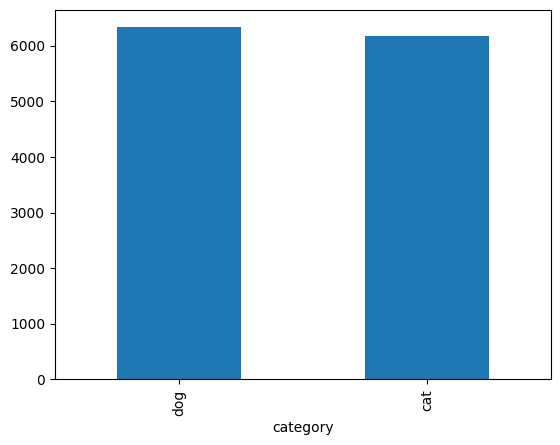

In [50]:
# see how many images classify into which class
test_df['category'].value_counts().plot.bar()

## **7.2. See Predicted Image With Images**

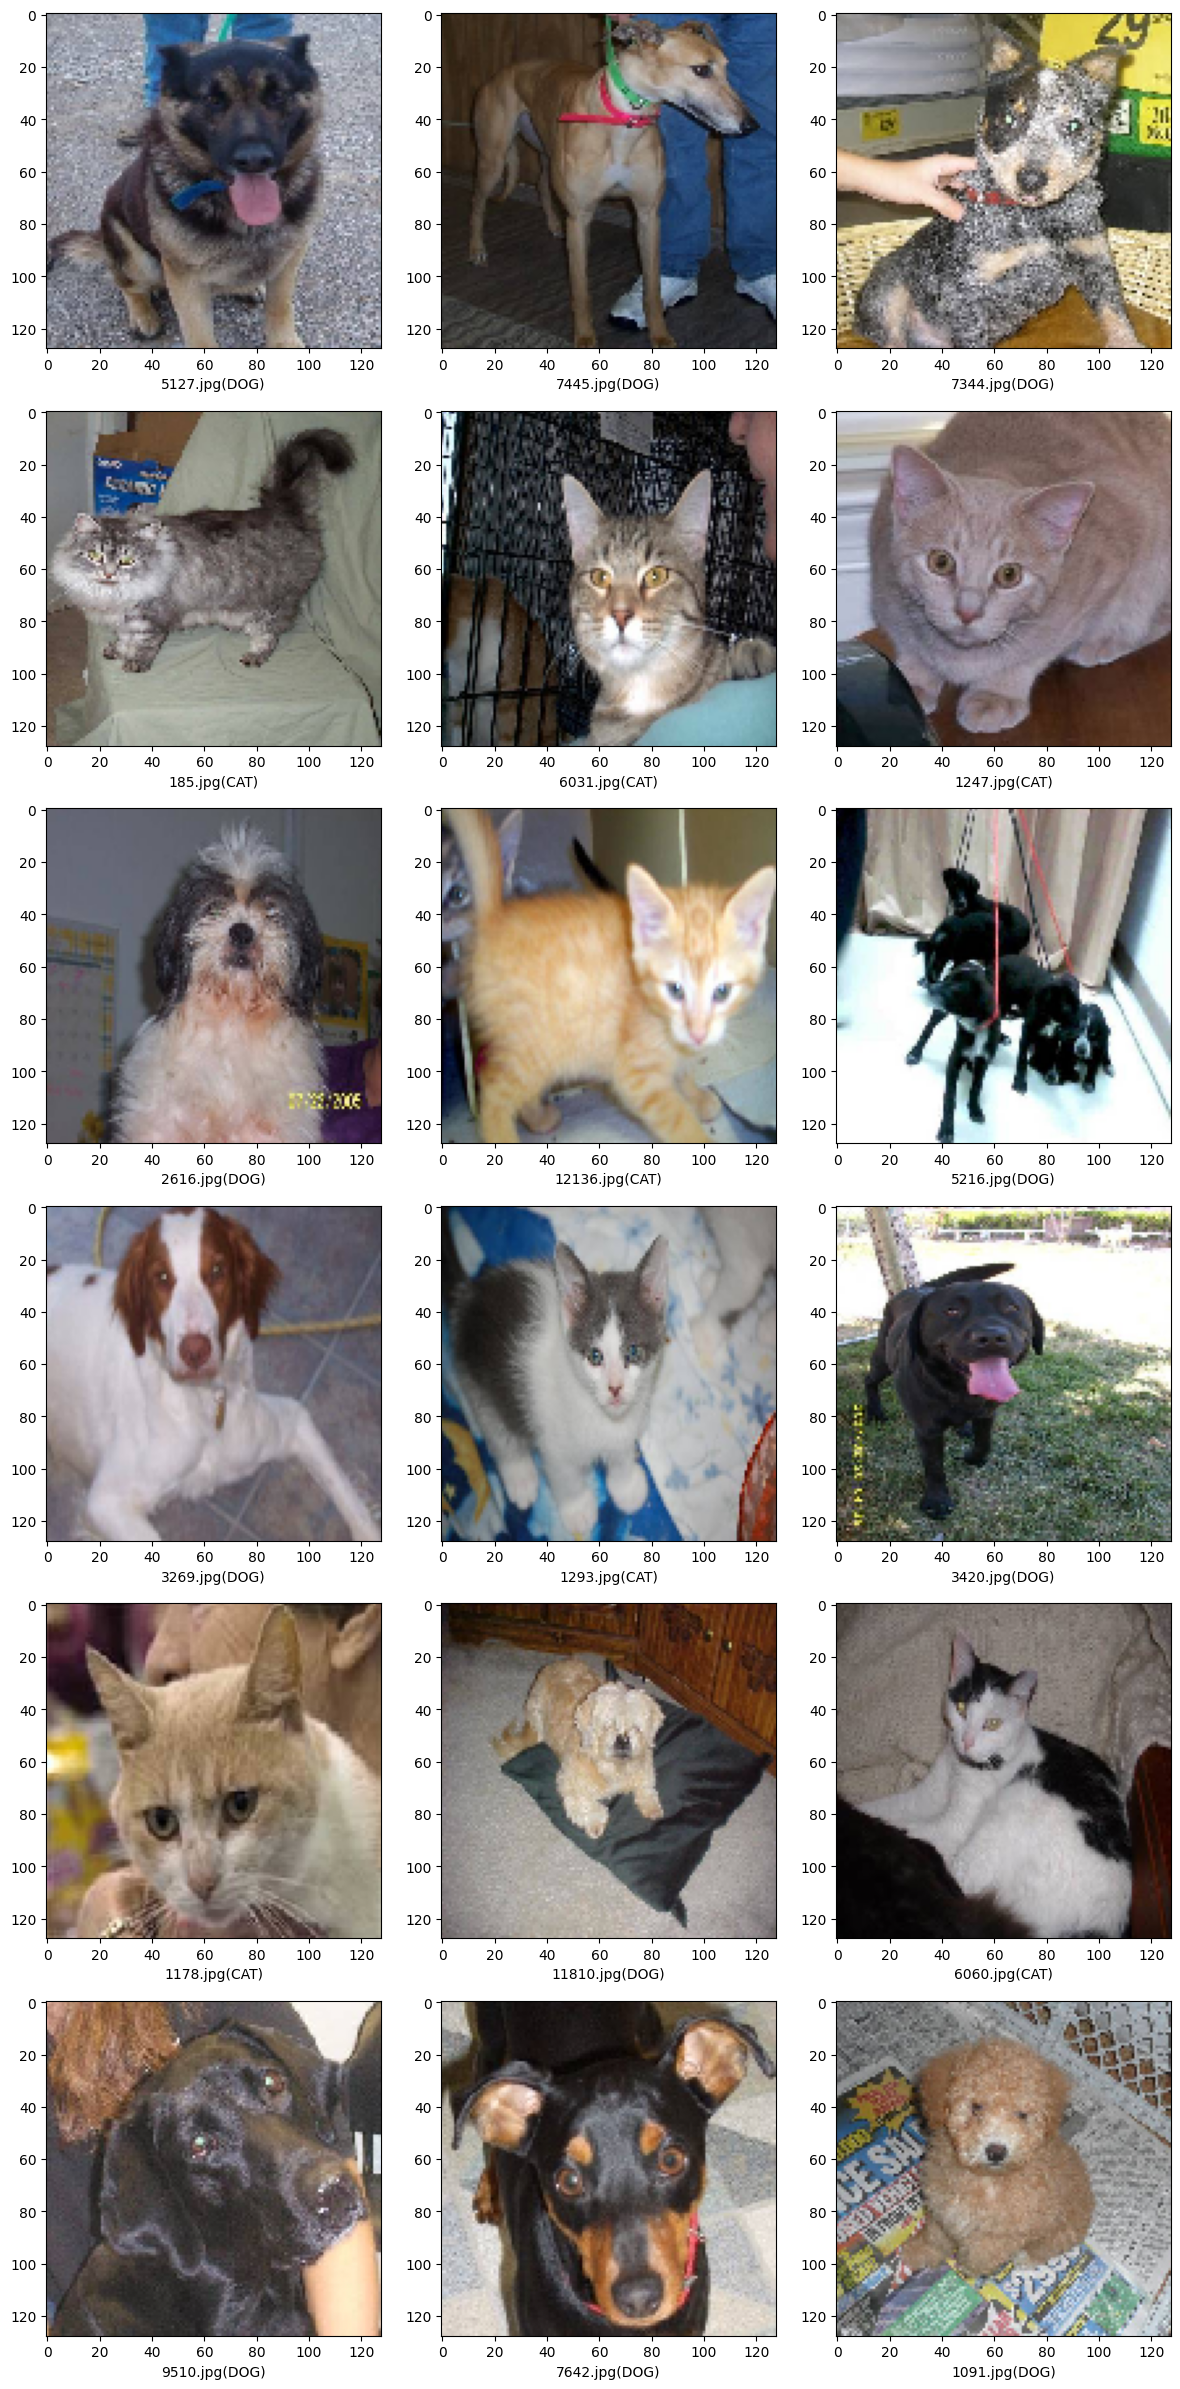

In [51]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/sample_data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category.upper()) + ')' )
plt.tight_layout()
plt.show()

If you get any issues during run this notebook.Feel free to contact.
[Linkedin](https://www.linkedin.com/in/sidharth178),
[Github](https://github.com/sidharth178)

Thank You.
